# Analyse ROMY Events - ROMY vs ADR

In [105]:
import os
import obspy as obs
import matplotlib.pyplot as plt
import numpy as np
# import multitaper

from obspy.clients.fdsn import Client


In [106]:
from functions.makeplot_spectra_comparison_fill import __makeplot_spectra_comparison_fill
from functions.compute_backazimuth import __compute_backazimuth
from functions.makeplot_waveform_comparison_cc import __makeplot_waveform_comparison_cc
from functions.makeplot_comparison_ccf import __makeplot_comparison_ccf
from functions.get_event_info import __get_event_info
from functions.compute_cross_wavelet_transform import __compute_cross_wavelet_transform
from functions.compute_cwt import __compute_cwt
from functions.makeplot_waveforms import __makeplot_waveforms

In [107]:
if os.uname().nodename == 'lighthouse':
    root_path = '/home/andbro/'
    data_path = '/home/andbro/kilauea-data/'
    archive_path = '/home/andbro/freenas/'
elif os.uname().nodename == 'kilauea':
    root_path = '/home/brotzer/'
    data_path = '/import/kilauea-data/'
    archive_path = '/import/freenas-ffb-01-data/'

## Configurations

In [108]:
config = {}

## output path for figures
config['path_to_figs'] = data_path+"romy_events/figures/"

## path to data archive
config['path_to_data'] = data_path+"romy_events/data/"

## Event Montenegro
# config['event_name'] = "Montenegro"
# config['tbeg'] = obs.UTCDateTime("2024-03-14 03:06")
# config['tend'] = obs.UTCDateTime("2024-03-14 03:36")
# dt1, dt2 = 120, 1100

## Event Morocco
config['event_name'] = "Morocco"
config['tbeg'] = obs.UTCDateTime("2023-09-08 22:00")
config['tend'] = obs.UTCDateTime("2023-09-08 23:00")
dt1, dt2 = 900, 1200

config['seis'] = "FUR"


config['filename'] = f"ROMY_{config['seis']}_{config['event_name']}_{str(config['tbeg'].date).replace('-','')}_6C.mseed"

config['Client'] = Client("USGS")

## ROMY coordinates
config['sta_lon'] = 11.275501
config['sta_lat'] = 48.162941



## Load Data

In [109]:
config, dist, baz, az = __get_event_info(config)

Event:	2023-09-08T22:11:01.405000Z | +31.058,   -8.385 | 6.8  mww | manual

	            resource_id: ResourceIdentifier(id="quakeml:earthquake.usgs.gov/fdsnws/event/1/query?eventid=us7000kufc&format=quakeml")
	             event_type: 'earthquake'
	          creation_info: CreationInfo(agency_id='us', creation_time=UTCDateTime(2024, 2, 5, 11, 32, 43, 840000))
	    preferred_origin_id: ResourceIdentifier(id="quakeml:earthquake.usgs.gov/product/origin/us7000kufc/us/1700250471040/product.xml")
	 preferred_magnitude_id: ResourceIdentifier(id="quakeml:earthquake.usgs.gov/product/origin/us7000kufc/us/1700250471040/product.xml#magnitude")
	                   ---------
	     event_descriptions: 1 Elements
	                origins: 1 Elements
	             magnitudes: 1 Elements
Distance  2526.012037508344 km Azimuth  35.64764658913597 Backazimuth  228.39689203768455


In [110]:
st0 = obs.read(config['path_to_data']+config['filename'])

st0 = st0.trim(config['tbeg']+dt1, config['tend']-dt2)


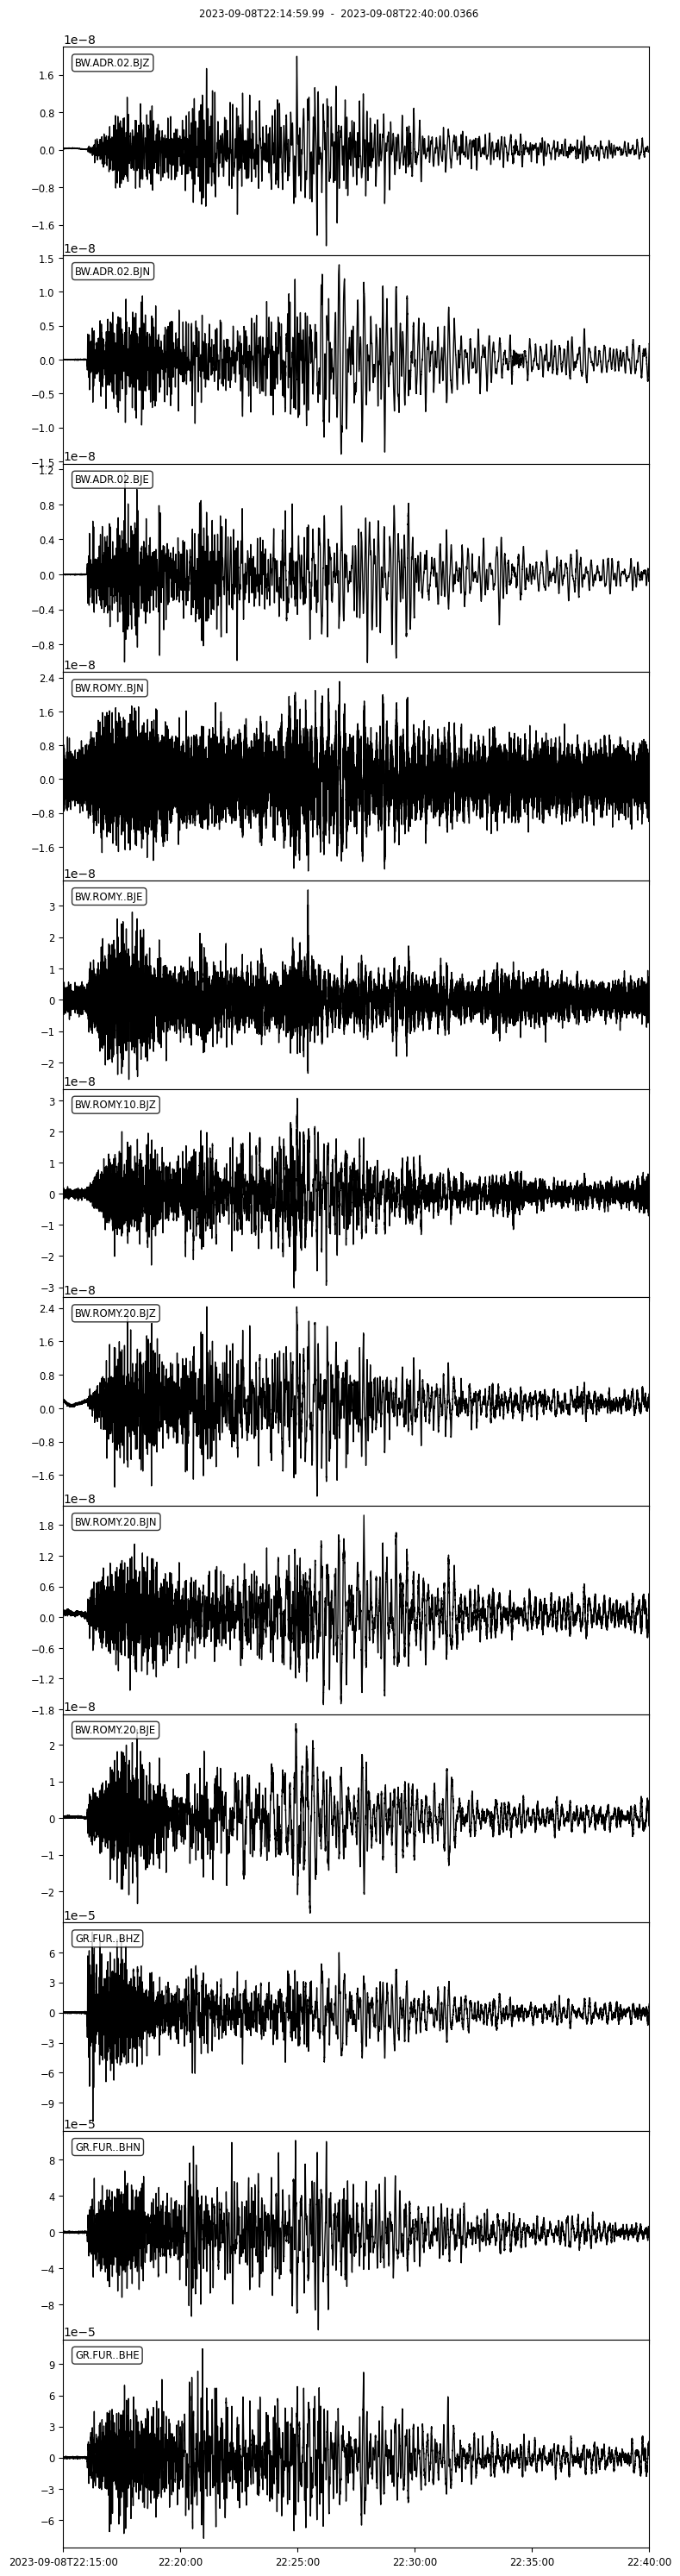

In [111]:
st0.plot(equal_scale=False);

In [112]:
st0

12 Trace(s) in Stream:
BW.ROMY.10.BJZ | 2023-09-08T22:15:00.011600Z - 2023-09-08T22:40:00.011600Z | 20.0 Hz, 30001 samples
BW.ROMY..BJN   | 2023-09-08T22:14:59.999399Z - 2023-09-08T22:39:59.999399Z | 20.0 Hz, 30001 samples
BW.ROMY..BJE   | 2023-09-08T22:15:00.036600Z - 2023-09-08T22:40:00.036600Z | 20.0 Hz, 30001 samples
GR.FUR..BHE    | 2023-09-08T22:14:59.990000Z - 2023-09-08T22:39:59.990000Z | 20.0 Hz, 30001 samples
GR.FUR..BHN    | 2023-09-08T22:14:59.990000Z - 2023-09-08T22:39:59.990000Z | 20.0 Hz, 30001 samples
GR.FUR..BHZ    | 2023-09-08T22:14:59.990000Z - 2023-09-08T22:39:59.990000Z | 20.0 Hz, 30001 samples
BW.ADR.02.BJZ  | 2023-09-08T22:14:59.990000Z - 2023-09-08T22:39:59.990000Z | 20.0 Hz, 30001 samples
BW.ADR.02.BJN  | 2023-09-08T22:14:59.990000Z - 2023-09-08T22:39:59.990000Z | 20.0 Hz, 30001 samples
BW.ADR.02.BJE  | 2023-09-08T22:14:59.990000Z - 2023-09-08T22:39:59.990000Z | 20.0 Hz, 30001 samples
BW.ROMY.20.BJZ | 2023-09-08T22:15:00.000000Z - 2023-09-08T22:40:00.000000Z | 

## Spectra

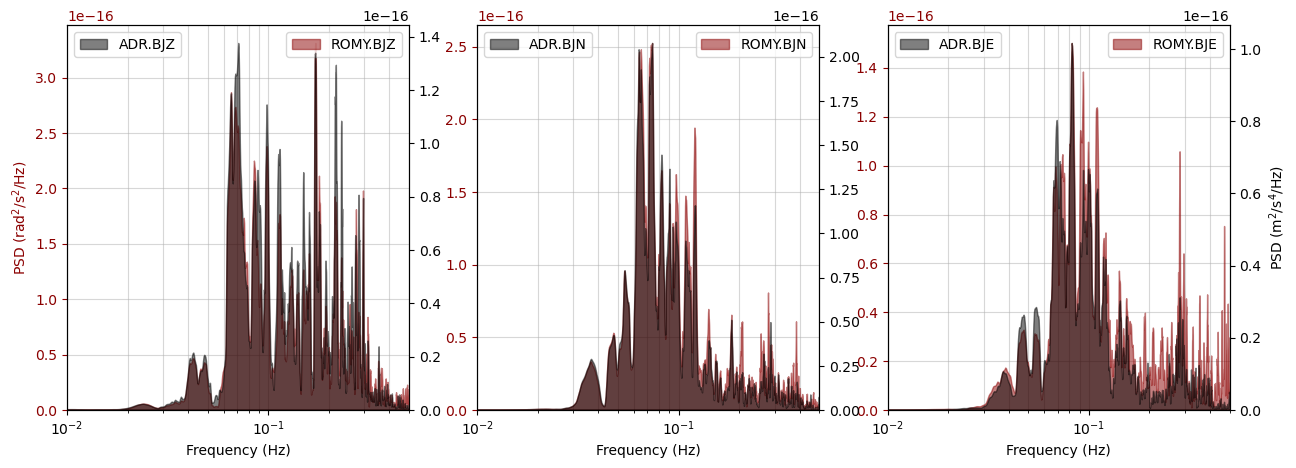

In [113]:

from functions.makeplot_spectra_comparison_fill import __makeplot_spectra_comparison_fill

rot0 = st0.select(station="ROMY", channel="*J*").copy()
acc0 = st0.select(station=config['seis'], channel="*H*").copy()
# adr01 = st0.select(station="ADR", location="01", channel="*J*").copy()
adr02 = st0.select(station="ADR", location="02", channel="*J*").copy()

rot0 = rot0.detrend("simple")
acc0 = acc0.detrend("simple")
# adr01 = adr01.detrend("simple")
adr02 = adr02.detrend("simple")

# fig = __makeplot_spectra_comparison_fill(rot0, adr01, fmin=0.1, fmax=1.0, ylog=False, xlog=True, fill=True)

fig = __makeplot_spectra_comparison_fill(rot0, adr02, fmin=0.01, fmax=0.5, ylog=False, xlog=True, fill=True)

# fig.savefig(config['path_to_figs']+f"ROMY_{config['event_name']}_spectra_all.png", format="png", dpi=150, bbox_inches='tight');


## Filter

In [114]:
def __adjust_polarity_and_scale(st0, x):

    for tr in st0:
        tr.data = tr.data * x[tr.stats.channel[-1]]

    return st0

In [115]:

fmin, fmax = 0.02, 0.1


rot2 = st0.select(station="ROMY", channel="*J*").copy()
acc2 = st0.select(station=config['seis'], channel="*H*").copy()
adr2 = st0.select(station="ADR", location="02", channel="*J*").copy()
adrx = st0.select(station="ROMY", location="20", channel="*J*").copy()


# for tr in adr2:
#     tr.data = np.roll(tr.data, 20)
# for tr in adrx:
#     tr.data = np.roll(tr.data, 20)

# x = {"N":-1, "E":5, "Z":-2} ## Morocco
# x = {"N":1, "E":-5, "Z":1} ## Montenegro

# adr2 = __adjust_polarity_and_scale(adr2, x)

rot2 = rot2.detrend("demean").taper(0.01).filter("bandpass", freqmin=fmin, freqmax=fmax, corners=4, zerophase=True);
acc2 = acc2.detrend("demean").taper(0.01).filter("bandpass", freqmin=fmin, freqmax=fmax, corners=4, zerophase=True);
adr2 = adr2.detrend("demean").taper(0.01).filter("bandpass", freqmin=fmin, freqmax=fmax, corners=4, zerophase=True);
adrx = adrx.detrend("demean").taper(0.01).filter("bandpass", freqmin=fmin, freqmax=fmax, corners=4, zerophase=True);


In [116]:
def __makeplot_waveforms_ADR(adr, rot, x):

    import matplotlib.pyplot as plt

    from matplotlib.gridspec import GridSpec
    from numpy import arange, mean, nan, nanmax
    from pandas import DataFrame
    from functions.get_octave_bands import __get_octave_bands
    from scipy.signal import coherence

    rot_scale, rot_unit = 1e9, "nrad/s"
    adr_scale, adr_unit = 1e9, "nrad/s"


    Nrow, Ncol = 3, 2
    font = 12
    lw = 1

    fig = plt.figure(figsize=(12, 5))

    gs = GridSpec(Nrow, Ncol, figure=fig)

    ax1 = fig.add_subplot(gs[0, :-1])
    ax2 = fig.add_subplot(gs[1, :-1])
    ax3 = fig.add_subplot(gs[2, :-1])

    ax4 = fig.add_subplot(gs[0, 1:])
    ax5 = fig.add_subplot(gs[1, 1:])
    ax6 = fig.add_subplot(gs[2, 1:])

    plt.subplots_adjust(hspace=0.1)

    cha='*Z'
    lbl = f"{rot.select(channel=cha)[0].stats.station}.{rot.select(channel=cha)[0].stats.channel}"
    ax1.plot(rot.select(channel=cha)[0].times(),
             rot.select(channel=cha)[0].data*rot_scale,
             color="k", label=lbl, lw=lw,
            )

    cha='*N'
    lbl = f"{rot.select(channel=cha)[0].stats.station}.{rot.select(channel=cha)[0].stats.channel}"
    ax2.plot(rot.select(channel=cha)[0].times(),
             rot.select(channel=cha)[0].data*rot_scale,
             color="k", label=lbl, lw=lw,
            )

    cha='*E'
    lbl = f"{rot.select(channel=cha)[0].stats.station}.{rot.select(channel=cha)[0].stats.channel}"
    ax3.plot(rot.select(channel=cha)[0].times(),
             rot.select(channel=cha)[0].data*rot_scale,
             color="k", label=lbl, lw=lw,
            )

    cha='*Z'
    lbl = f"{x[cha[-1]]}x {adr.select(channel=cha)[0].stats.station}.{adr.select(channel=cha)[0].stats.channel}"
    ax4.plot(adr.select(channel=cha)[0].times(),
             adr.select(channel=cha)[0].data*adr_scale,
             color="k", label=lbl, lw=lw,
            )

    cha='*N'
    lbl = f"{x[cha[-1]]}x {adr.select(channel=cha)[0].stats.station}.{adr.select(channel=cha)[0].stats.channel}"
    ax5.plot(adr.select(channel=cha)[0].times(),
             adr.select(channel=cha)[0].data*adr_scale,
             color="k", label=lbl, lw=lw,
            )

    cha='*E'
    lbl = f"{x[cha[-1]]}x {adr.select(channel=cha)[0].stats.station}.{adr.select(channel=cha)[0].stats.channel}"
    ax6.plot(adr.select(channel=cha)[0].times(),
             adr.select(channel=cha)[0].data*adr_scale,
             color="k", label=lbl, lw=lw,
            )


    for ax in [ax1, ax2, ax3, ax4 ,ax5, ax6]:
        ax.legend(loc=1, fontsize=font-3, bbox_to_anchor=(0.95, 1.10), ncol=2)
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
        if ax not in [ax3, ax6]:
            ax.set(xticklabels=[])
            ax.tick_params(bottom=False)
            ax.spines['bottom'].set_visible(False)
        if ax in [ax3, ax6]:
            ax.set_xlabel(f"Time (s) from {adr[0].stats.starttime.date} {str(adr[0].stats.starttime.time).split('.')[0]} UTC")

    for ax in [ax1, ax2, ax3]:
        ax.set_ylabel(f"$\Omega$ ({rot_unit})", fontsize=font)

    for ax in [ax4, ax5, ax6]:
        ax.set_ylabel(f"$\Omega$ ({adr_unit})", fontsize=font)


    return fig

In [117]:
# fig = __makeplot_waveforms_ADR(adr2, rot2, x);

# fig.savefig(config['path_to_figs']+f"ROMY_{config['event_name']}_waveforms.png", format="png", dpi=200, bbox_inches='tight')


In [1]:
def __makeplot_ADR(st1, st2, x):

    import matplotlib.pyplot as plt
    import numpy as np
    from matplotlib.gridspec import GridSpec
    from functions.multitaper_psd import __multitaper_psd
    from functions.welch_psd import __welch_psd
    from functions.get_fft import __get_fft


    def __integrate(stt, dat):
        _st = stt.copy()
        _st.data = dat
        _st.integrate()
        return _st.data

    def __rmse(arr1, arr2):
        return np.round(np.sqrt(np.mean((arr1-arr2)**2)), 4)

    def __get_residual_percent(dat1, dat2):
        imax, vmax = np.argmax(abs(dat2-dat1)), np.amax(abs(dat2-dat1))
        pmax = round(np.amax(dat2-dat1)/dat1[imax]*100, 2)
        return pmax

    def __to_dB(psd):
        return 10*np.log10(psd)

    def __get_lim(arrs):
        mins = [min(arr) for arr in arrs]
        maxs = [max(arr) for arr in arrs]
        return min(mins + maxs), max(mins + maxs)


    tscale, tunit = 1/60, "min"

    times = st1.select(channel="*N")[0].times()

    Ncol, Nrow = 6, 13

    font = 12

    lw = 1

    scale, unit = 1e9, f"nrad/s"

    fig = plt.figure(figsize=(15, 12))

    gs = GridSpec(Nrow, Ncol, figure=fig, hspace=0)
    gs2 = GridSpec(Nrow, Ncol, figure=fig, hspace=10000)

    ax1 = fig.add_subplot(gs[0:2, :])
    ax2 = fig.add_subplot(gs[2, :])
    ax3 = fig.add_subplot(gs[3:5, :])
    ax4 = fig.add_subplot(gs[5, :])
    ax5 = fig.add_subplot(gs[6:8, :])
    ax6 = fig.add_subplot(gs[8, :])

    ax7 = fig.add_subplot(gs2[9:12, 0:2])
    ax8 = fig.add_subplot(gs2[9:12, 2:4])
    ax9 = fig.add_subplot(gs2[9:12, 4:6])

    accN = st1.select(channel="*N")[0].data*scale
    accE = st1.select(channel="*E")[0].data*scale
    accZ = st1.select(channel="*Z")[0].data*scale

    accN_c = st2.select(channel="*N")[0].data*scale*x["N"]
    accE_c = st2.select(channel="*E")[0].data*scale*x["E"]
    accZ_c = st2.select(channel="*Z")[0].data*scale*x["Z"]

    # psd before and after
    dt = st1.select(channel="*N")[0].stats.delta
    # fN1, psdN1 = __multitaper_psd(accN/scale, dt, n_win=5, time_bandwidth=3.0)
    # fN2, psdN2 = __multitaper_psd(accN_c/scale, dt, n_win=5, time_bandwidth=3.0)
    # fE1, psdE1 = __multitaper_psd(accE/scale, dt, n_win=5, time_bandwidth=3.0)
    # fE2, psdE2 = __multitaper_psd(accE_c/scale, dt, n_win=5, time_bandwidth=3.0)

#     fN1, psdN1 = __welch_psd(accN/scale, dt, twin_sec=150)
#     fN2, psdN2 = __welch_psd(accN_c/scale, dt, twin_sec=150)
#     fE1, psdE1 = __welch_psd(accE/scale, dt, twin_sec=150)
#     fE2, psdE2 = __welch_psd(accE_c/scale, dt, twin_sec=150)
#     fZ1, psdZ1 = __welch_psd(accZ/scale, dt, twin_sec=150)
#     fZ2, psdZ2 = __welch_psd(accZ_c/scale, dt, twin_sec=150)

    fN1, psdN1, _ = __get_fft(accN/scale, dt, window="hann")
    fN2, psdN2, _ = __get_fft(accN_c/scale, dt, window="hann")
    fE1, psdE1, _ = __get_fft(accE/scale, dt, window="hann")
    fE2, psdE2, _ = __get_fft(accE_c/scale, dt, window="hann")
    fZ1, psdZ1, _ = __get_fft(accZ/scale, dt, window="hann")
    fZ2, psdZ2, _ = __get_fft(accZ_c/scale, dt, window="hann")

    ax1.plot(times*tscale, accN, color="black", label="ROMY-N", lw=lw)
    ax1.plot(times*tscale, accN_c, color="tab:blue", label=f"{x['N']}x ADR-N", lw=lw)

    ax2.plot(times*tscale, (accN-accN_c), color="grey", label=f"RMSE = {__rmse(accN, accN_c)}, max = {__get_residual_percent(accN, accN_c)}%", lw=lw)


    ax3.plot(times*tscale, accE, color="black", label="ROMY-E", lw=lw)
    ax3.plot(times*tscale, accE_c, color="tab:red", label=f"{x['E']}x ADR-E", lw=lw)

    ax4.plot(times*tscale, (accE-accE_c), color="grey", label=f"RMSE = {__rmse(accE, accE_c)}, max = {__get_residual_percent(accE, accE_c)}%", lw=lw)

    ax5.plot(times*tscale, accZ, color="black", label="ROMY-Z", lw=lw)
    ax5.plot(times*tscale, accZ_c, color="tab:green", label=f"{x['Z']}x ADR-Z", lw=lw)

    ax6.plot(times*tscale, (accZ-accZ_c), color="grey", label=f"RMSE = {__rmse(accZ, accZ_c)}, max = {__get_residual_percent(accZ, accZ_c)}%", lw=lw)


    ax7.plot(fN1, psdN1*1e9, label="ROMY-N", color="tab:blue")
    ax7.plot(fN2, psdN2*1e9, label=f"{x['N']}x ADR-N", color="darkblue", ls="--")
    # ax7.fill_between(fN2, __to_dB(psdN1), __to_dB(psdN2), color="tab:blue", alpha=0.3)

    ax8.plot(fE1, psdE1*1e9, label="ROMY-E", color="tab:red")
    ax8.plot(fE2, psdE2*1e9, label=f"{x['E']}x ADR-E", color="darkred", ls="--")
    # ax8.fill_between(fN2, __to_dB(psdE1), __to_dB(psdE2), color="tab:red", alpha=0.3)

    ax9.plot(fZ1, psdZ1*1e9, label="ROMY-Z", color="tab:green")
    ax9.plot(fZ2, psdZ2*1e9, label=f"{x['Z']}x ADR-Z", color="darkgreen", ls="--")
    # ax9.fill_between(fZ2, __to_dB(psdZ1), __to_dB(psdZ2), color="tab:red", alpha=0.3)

    y_max = max([max(psdN1), max(psdE1), max(psdZ1)]) * scale

    for ax in [ax7, ax8, ax9]:
        ax.set_xscale("log")
        # ax.set_yscale("log")
        ax.set_xlim(fmin, fmax)
        ax.legend(loc=9, ncol=2)
        ax.set_xticklabels([])
        ax.set_ylim(top=y_max)
        ax.set_xlabel(f"Frequency (Hz)", fontsize=font, labelpad=0)

    ax8.tick_params(labelleft=False, left=True)
    ax9.tick_params(labelleft=False, left=True)


    for ax in [ax1, ax3, ax5]:
        ax.legend(loc=1, ncol=2)

    ax1.set_ylabel(f"rotation rate\n({unit})", fontsize=font)
    ax3.set_ylabel(f"rotation rate\n({unit})", fontsize=font)
    ax5.set_ylabel(f"rotation rate\n({unit})", fontsize=font)
    # ax7.set_ylabel(f"PSD\n(dB wrt 1 rad$^2$/s$^2$/Hz)", fontsize=font)
    sqrt=r"$\sqrt{Hz}$"
    ax7.set_ylabel(f"spectrum\n(nrad/s/{sqrt})", fontsize=font)

    ax2.set_ylabel(f"residual\n({unit})", fontsize=font)
    ax4.set_ylabel(f"residual\n({unit})", fontsize=font)
    ax6.set_ylabel(f"residual\n({unit})", fontsize=font)

    for ax in [ax1, ax2, ax3, ax5]:
        ax.get_xaxis().set_visible(False)

    ax6.set_xlabel(f"Time ({tunit}) from {st1[0].stats.starttime.date} {str(st1[0].stats.starttime.time).split('.')[0]} UTC", fontsize=font, labelpad=0)

    ax1.text(.005, .97, "(a)", ha='left', va='top', transform=ax1.transAxes, fontsize=font+2)
    ax2.text(.005, .97, "(b)", ha='left', va='top', transform=ax2.transAxes, fontsize=font+2)
    ax3.text(.005, .97, "(c)", ha='left', va='top', transform=ax3.transAxes, fontsize=font+2)
    ax4.text(.005, .97, "(d)", ha='left', va='top', transform=ax4.transAxes, fontsize=font+2)
    ax5.text(.005, .97, "(e)", ha='left', va='top', transform=ax5.transAxes, fontsize=font+2)
    ax6.text(.005, .97, "(f)", ha='left', va='top', transform=ax6.transAxes, fontsize=font+2)
    ax7.text(.005, .97, "(g)", ha='left', va='top', transform=ax7.transAxes, fontsize=font+2)
    ax8.text(.005, .97, "(h)", ha='left', va='top', transform=ax8.transAxes, fontsize=font+2)
    ax9.text(.005, .97, "(i)", ha='left', va='top', transform=ax9.transAxes, fontsize=font+2)

    txt = f"RMSE = {__rmse(accN, accN_c)}, max = {__get_residual_percent(accN, accN_c)}%"
    ax2.text(.99, .97, txt, ha='right', va='top', transform=ax2.transAxes, fontsize=font-2)

    txt = f"RMSE = {__rmse(accE, accE_c)}, max = {__get_residual_percent(accE, accE_c)}%"
    ax4.text(.99, .97, txt, ha='right', va='top', transform=ax4.transAxes, fontsize=font-2)

    txt = f"RMSE = {__rmse(accZ, accZ_c)}, max = {__get_residual_percent(accZ, accZ_c)}%"
    ax6.text(.99, .97, txt, ha='right', va='top', transform=ax6.transAxes, fontsize=font-2)

    ax1.set_title(f"{st1[0].stats.station} & {st2[0].stats.station} | f = {fmin} - {fmax} Hz")

    plt.plot();
    return fig

fig = __makeplot_ADR(rot2, adr2, {"N":1, "E":1, "Z":1})

# fig.savefig(config['path_to_figs']+f"RomyTiltCorrection_{config['event_name']}_{config['tbeg'].date}_{rot2[0].stats.station}_{adr2[0].stats.station}.png", format="png", dpi=150, bbox_inches='tight')


NameError: name 'rot2' is not defined

### ADR of archive

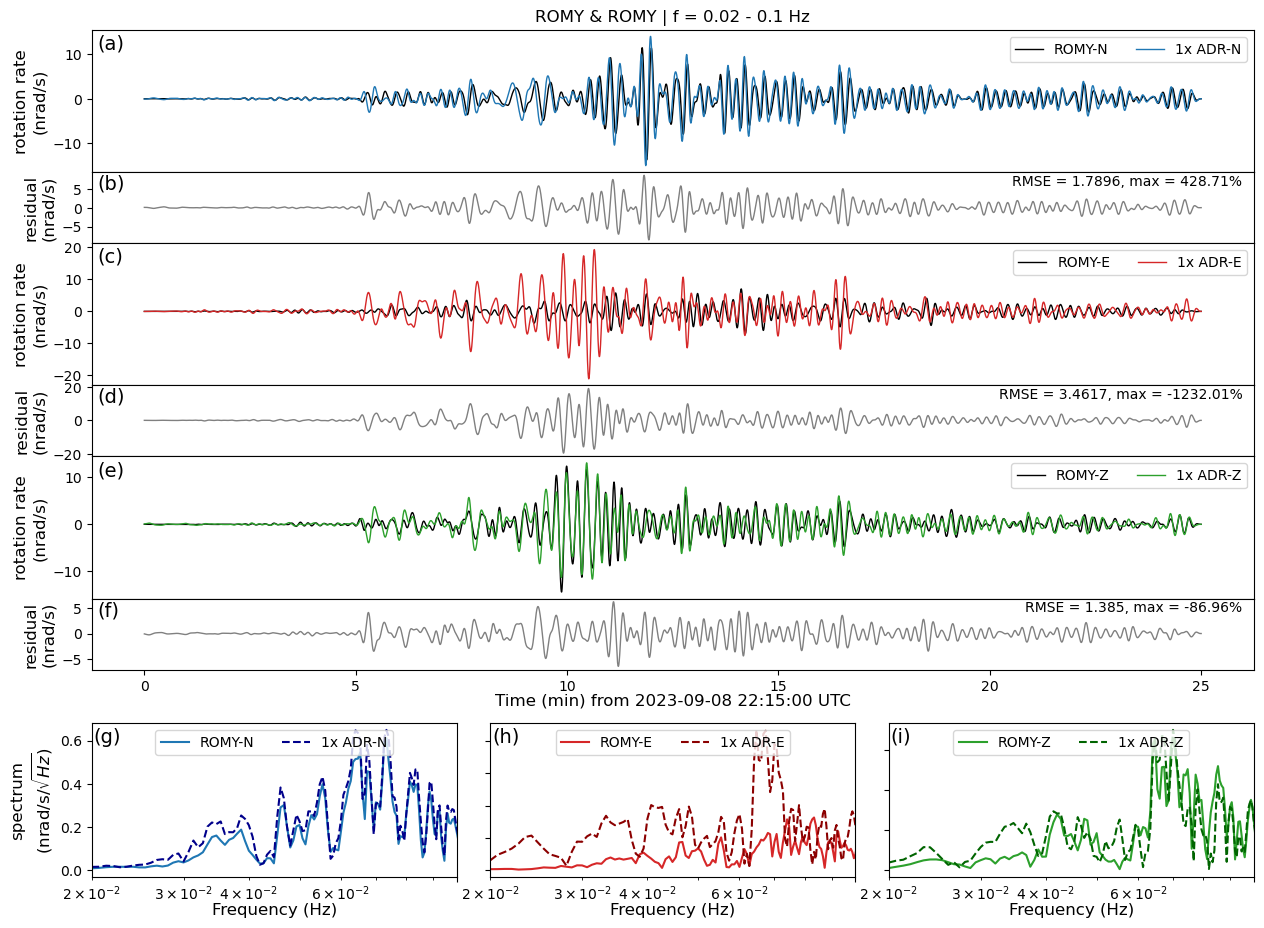

In [119]:
fig = __makeplot_ADR(rot2, adrx, {"N":1, "E":1, "Z":1}) ## Morocco


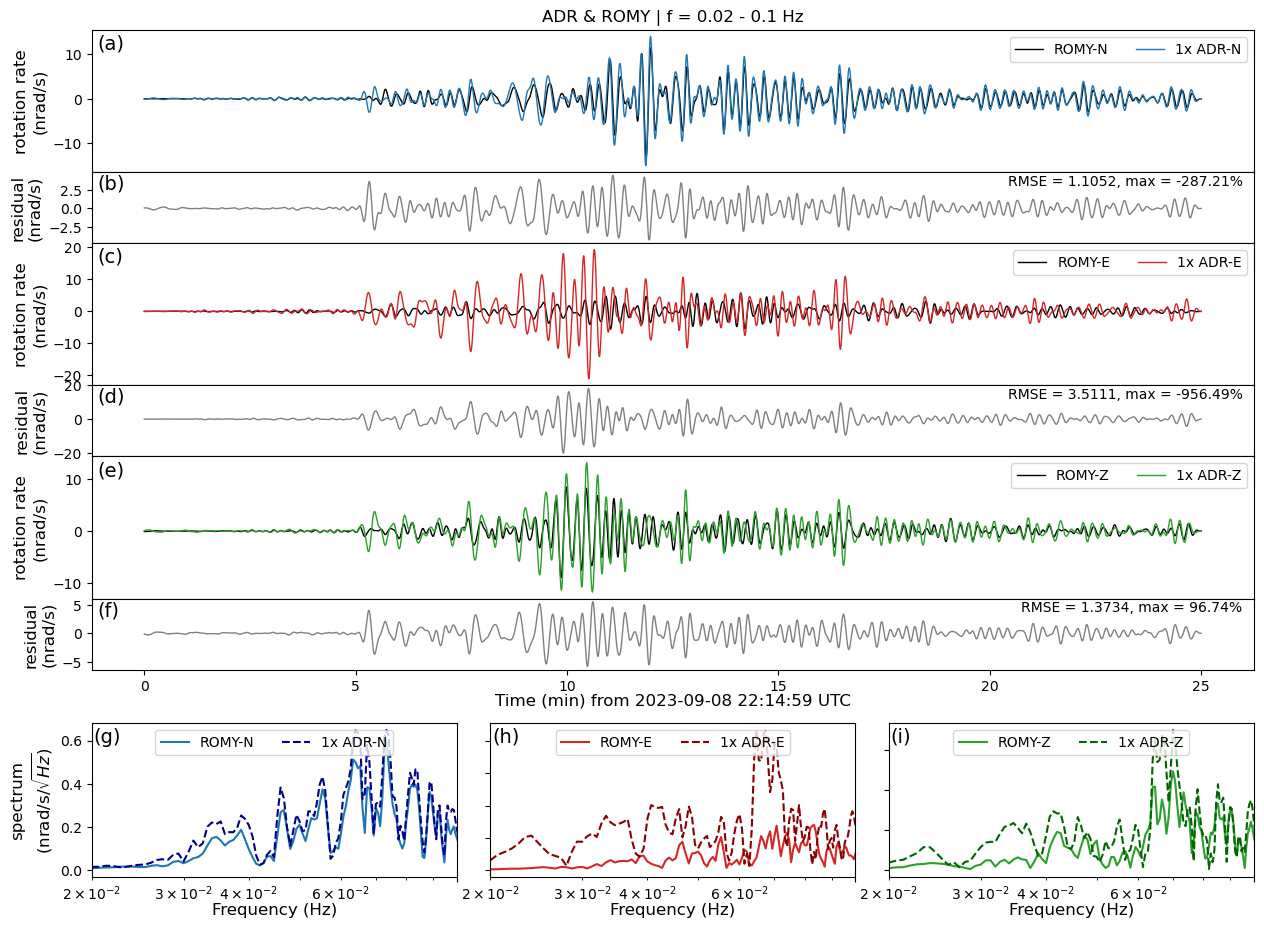

In [120]:
fig = __makeplot_ADR(adr2, adrx, {"N":1, "E":1, "Z":1}) ## Morocco


### ADR of inner array

In [223]:

fmin, fmax = 0.2, 1.0


rot1 = st0.select(station="ROMY", channel="*J*").copy()
acc1 = st0.select(station=config['seis'], channel="*H*").copy()
adr1 = st0.select(station="ADR", location="01", channel="*J*").copy()

x = {"N":-1, "E":5, "Z":-2} ## Morocco
x = {"N":1, "E":1, "Z":1} ## Montenegro

# x = {"N":1, "E":1, "Z":1}

adr1 = __adjust_polarity_and_scale(adr1, x)

rot1 = rot1.detrend("linear").taper(0.01).filter("bandpass", freqmin=fmin, freqmax=fmax, corners=4, zerophase=True);
acc1 = acc1.detrend("linear").taper(0.01).filter("bandpass", freqmin=fmin, freqmax=fmax, corners=4, zerophase=True);
adr1 = adr1.detrend("linear").taper(0.01).filter("bandpass", freqmin=fmin, freqmax=fmax, corners=4, zerophase=True);


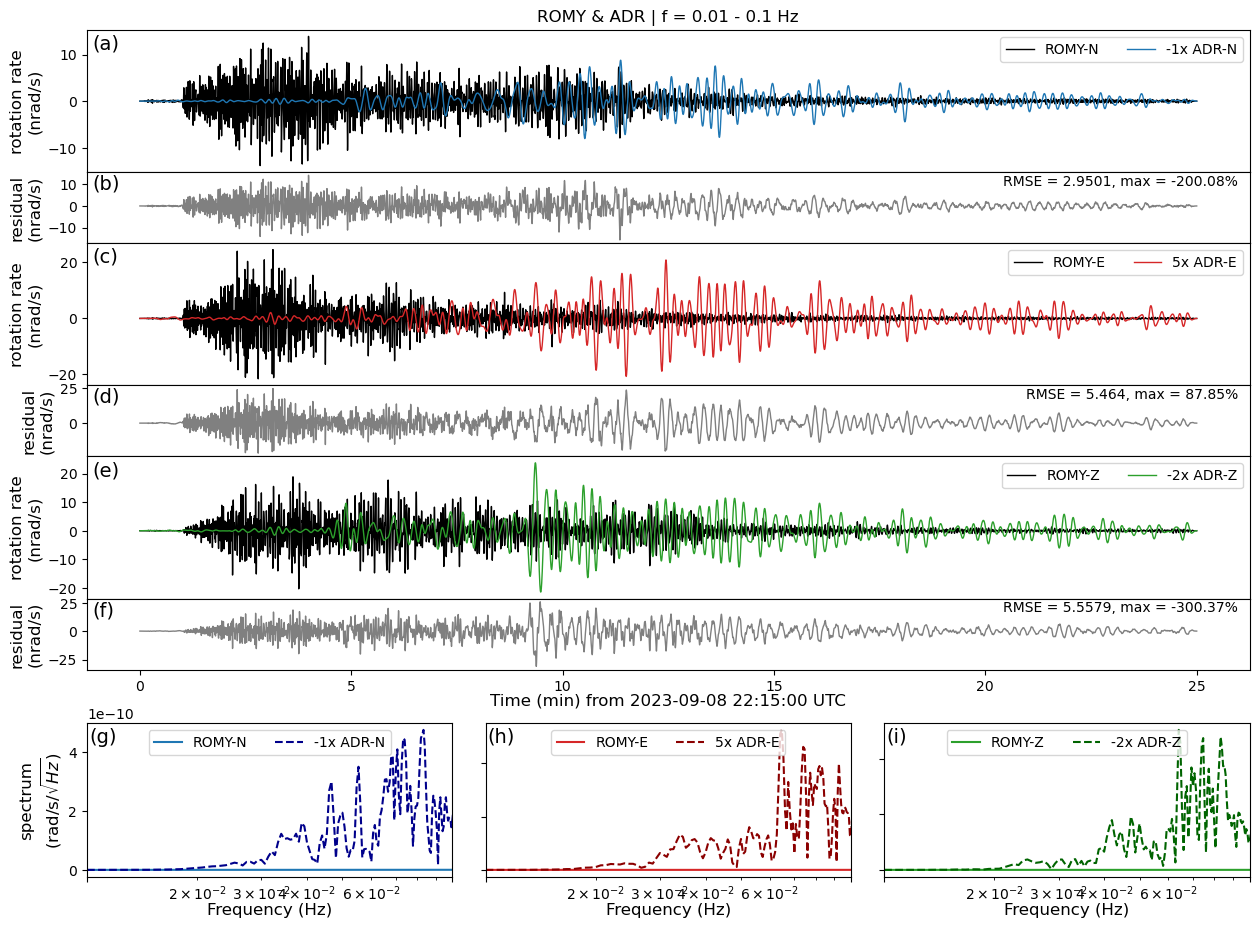

In [205]:
fig = __makeplot_ADR(rot1, adr1, x)

In [206]:
def __makeplot(st1, st2):

    import matplotlib.pyplot as plt
    import numpy as np
    from matplotlib.gridspec import GridSpec
    from functions.multitaper_psd import __multitaper_psd
    from functions.welch_psd import __welch_psd

    def __integrate(stt, dat):
        _st = stt.copy()
        _st.data = dat
        _st.integrate()
        return _st.data

    def __rmse(arr1, arr2):
        return np.round(np.sqrt(np.mean((arr1-arr2)**2)), 4)

    def __get_residual_percent(dat1, dat2):
        imax, vmax = np.argmax(abs(dat2-dat1)), np.amax(abs(dat2-dat1))
        pmax = round(np.amax(dat2-dat1)/dat1[imax]*100, 2)
        return pmax

    def __to_dB(psd):
        return 10*np.log10(psd)

    def __get_lim(arrs):
        mins = [min(arr) for arr in arrs]
        maxs = [max(arr) for arr in arrs]
        return min(mins + maxs), max(mins + maxs)


    tscale, tunit = 1/60, "min"

    times = st1.select(channel="*N")[0].times()

    Ncol, Nrow = 1, 11

    font = 12

    lw = 1

    scale, unit = 1e6, f"$\mu$m/s$^2$"

    fig = plt.figure(figsize=(15, 10))

    gs = GridSpec(Nrow, Ncol, figure=fig, hspace=0)
    gs2 = GridSpec(Nrow, Ncol, figure=fig, hspace=10000)

    ax1 = fig.add_subplot(gs[0:2, :])
    ax2 = fig.add_subplot(gs[2, :])
    ax3 = fig.add_subplot(gs[3:5, :])
    ax4 = fig.add_subplot(gs[5, :])

    ax5 = fig.add_subplot(gs2[6:9, :])
    ax6 = fig.add_subplot(gs[9:11, :])

    accN = st1.select(channel="*N")[0].data*scale
    accE = st1.select(channel="*E")[0].data*scale

    accN_c = st2.select(channel="*N")[0].data*scale
    accE_c = st2.select(channel="*E")[0].data*scale

    # psd before and after
    dt = st1.select(channel="*N")[0].stats.delta
    # fN1, psdN1 = __multitaper_psd(accN/scale, dt, n_win=5, time_bandwidth=3.0)
    # fN2, psdN2 = __multitaper_psd(accN_c/scale, dt, n_win=5, time_bandwidth=3.0)
    # fE1, psdE1 = __multitaper_psd(accE/scale, dt, n_win=5, time_bandwidth=3.0)
    # fE2, psdE2 = __multitaper_psd(accE_c/scale, dt, n_win=5, time_bandwidth=3.0)

    fN1, psdN1 = __welch_psd(accN/scale, dt, twin_sec=150)
    fN2, psdN2 = __welch_psd(accN_c/scale, dt, twin_sec=150)
    fE1, psdE1 = __welch_psd(accE/scale, dt, twin_sec=150)
    fE2, psdE2 = __welch_psd(accE_c/scale, dt, twin_sec=150)

    ax1.plot(times*tscale, accN, color="black", label="N$_{observed}$", lw=lw)
    ax1.plot(times*tscale, accN_c, color="tab:blue", label="N$_{corrected}$", lw=lw)

    ax2.plot(times*tscale, (accN-accN_c), color="grey", label=f"RMSE = {__rmse(accN, accN_c)}, max = {__get_residual_percent(accN, accN_c)}%", lw=lw)


    ax3.plot(times*tscale, accE, color="black", label="E$_{observed}$", lw=lw)
    ax3.plot(times*tscale, accE_c, color="tab:red", label="E$_{corrected}$", lw=lw)

    ax4.plot(times*tscale, (accE-accE_c), color="grey", label=f"RMSE = {__rmse(accE, accE_c)}, max = {__get_residual_percent(accE, accE_c)}%", lw=lw)


    ax5.plot(fN1, __to_dB(psdN1), label="N$_{observed}$", color="tab:blue")
    ax5.plot(fN2, __to_dB(psdN2), label="N$_{corrected}$", color="darkblue", ls="--")
    # ax5.fill_between(fN2, __to_dB(psdN1), __to_dB(psdN2), color="tab:blue", alpha=0.3)

    ax5.plot(fE1, __to_dB(psdE1), label="E$_{observed}$", color="tab:red")
    ax5.plot(fE2, __to_dB(psdE2), label="E$_{corrected}$", color="darkred", ls="--")
    # ax5.fill_between(fN2, __to_dB(psdE1), __to_dB(psdE2), color="tab:red", alpha=0.3)

    # ax5.fill_between(fN1, 0, __to_dB(psdN2) - __to_dB(psdN1), label="N diff", color="tab:blue", alpha=0.4)
    # ax5.fill_between(fE1, 0, __to_dB(psdE2) - __to_dB(psdE1), label="E diff", color="tab:red", alpha=0.4)


    # ax5.set_ylim(-160, -135)
    # ax5.set_ylim(-170, -140)
    ax5.set_xscale("log")
    ax5.set_xlim(fmin, fmax)
    ax5.legend(loc=4)
    ax5.set_xticklabels([])

    diffN = __to_dB(psdN2) - __to_dB(psdN1)
    diffE = __to_dB(psdE2) - __to_dB(psdE1)
    ax6.plot(fN1, diffN, label="N$_{residual}$", color="tab:blue")
    ax6.plot(fE1, diffE, label="E$_{residual}$", color="tab:red")
    # ax6.fill_between(fN1, 0, diffN, label="N$_{residual}$", color="tab:blue", alpha=0.4)
    # ax6.fill_between(fE1, 0, diffE, label="E$_{residual}$", color="tab:red", alpha=0.4)

    ax6.plot([fmin, fmax], [0, 0], alpha=0.2, color="k", zorder=0)

    min_lim, max_lim = __get_lim([diffN, diffE])
    ax6.set_ylim(min_lim*1.2, max_lim*1.2)

    ax6.set_xlim(fmin, fmax)
    ax6.set_xscale("log")
    ax6.legend(loc=4)
    ax6.set_ylim()


    for ax in [ax1, ax3]:
        ax.legend(loc=1, ncol=2)

    ax1.set_ylabel(f"acceleration\n({unit})", fontsize=font)
    ax3.set_ylabel(f"acceleration\n({unit})", fontsize=font)
    ax5.set_ylabel(f"PSD\n(dB wrt 1 m/s$^2/Hz$)", fontsize=font)
    ax6.set_ylabel(f"PSD residual\n(dB wrt 1 m/s$^2/Hz$)", fontsize=font)

    ax2.set_ylabel(f"residual\n({unit})", fontsize=font)
    ax4.set_ylabel(f"residual\n({unit})", fontsize=font)

    for ax in [ax1, ax2, ax3, ax5]:
        ax.get_xaxis().set_visible(False)

#     ax3.set_ylabel(f"East Tilt ({tilt_unit})", fontsize=font)
#     ax4.set_ylabel(f"Residual \n ({tilt_unit})", fontsize=font)
    ax4.set_xlabel(f"Time ({tunit}) from {st1[0].stats.starttime.date} {str(st1[0].stats.starttime.time).split('.')[0]} UTC", fontsize=font, labelpad=-1)
    ax6.set_xlabel(f"Frequency (Hz)", fontsize=font, labelpad=-1)

    ax1.text(.005, .97, "(a)", ha='left', va='top', transform=ax1.transAxes, fontsize=font+2)
    ax2.text(.005, .97, "(b)", ha='left', va='top', transform=ax2.transAxes, fontsize=font+2)
    ax3.text(.005, .97, "(c)", ha='left', va='top', transform=ax3.transAxes, fontsize=font+2)
    ax4.text(.005, .97, "(d)", ha='left', va='top', transform=ax4.transAxes, fontsize=font+2)
    ax5.text(.005, .97, "(e)", ha='left', va='top', transform=ax5.transAxes, fontsize=font+2)
    ax6.text(.005, .97, "(f)", ha='left', va='top', transform=ax6.transAxes, fontsize=font+2)

    txt = f"RMSE = {__rmse(accN, accN_c)}, max = {__get_residual_percent(accN, accN_c)}%"
    ax2.text(.99, .97, txt, ha='right', va='top', transform=ax2.transAxes, fontsize=font-2)

    txt = f"RMSE = {__rmse(accE, accE_c)}, max = {__get_residual_percent(accE, accE_c)}%"
    ax4.text(.99, .97, txt, ha='right', va='top', transform=ax4.transAxes, fontsize=font-2)

    ax1.set_title(f"{st1[0].stats.station} & {st2[0].stats.station} | f = {fmin} - {fmax} Hz")

    plt.plot();
    return fig

# fig = __makeplot(rot1, adr1)


## Waveform Comparison

In [207]:

out = __compute_cross_wavelet_transform(
                                        rot0[0].times(),
                                        rot0.select(channel=f"*{component}")[0].data,
                                        acc0.select(channel=f"*{component}")[0].data,
                                        rot0[0].stats.delta,
                                        xwt_threshold=0.,
                                        ymax=10,
                                        normalize=False,
                                        ylog=True,
                                        clog=True,
                                        plot=True,
)

# out['fig'].savefig(config['path_to_figs']+f"ROMY_{config['event_name']}_xwt_{component}.png", dpi=200, bbox_inches='tight', pad_inches=0.05)


NameError: name 'component' is not defined

In [ ]:
from scipy.signal import hilbert
from obspy.signal.tf_misfit import plot_tf_misfits

for component in ["Z", "N", "E"]:

    st1 = st0.copy()

    st1 = st1.detrend("demean").taper(0.01, type="cosine").filter("bandpass", freqmin=0.01, freqmax=10, corners=4, zerophase=True)

    s1 = st1.select(station="ROMY", channel=f"*{component}")[0].data
    s2 = st1.select(station="FUR", channel=f"*{component}")[0].data

    plot_tf_misfits(s1, s2, dt=st1[0].stats.delta, fmin=0.01, fmax=20, show=True, norm="global")


In [ ]:
for tr in acc1:
    if "Z" in tr.stats.channel:
        tr.data *= -1

# fig = __makeplot_waveform_comparison_cc(rot1, acc1, baz, fmin, fmax, dist, twin_sec=15, twin_overlap=0.5)

# fig.savefig(config['path_to_figs']+f"ROMY_{config['event_name']}_waveforms_cc.png", format="png", dpi=150, bbox_inches='tight');


In [ ]:
fig = __makeplot_comparison_ccf(rot1, acc1, baz, dist, twin_sec=10, twin_overlap=0.5, fmin=fmin, fmax=fmax)

## Backazimuth

In [ ]:
from functions.compute_backazimuth import __compute_backazimuth
from functions.get_theoretical_backazimuth import __get_theoretical_backazimuth
from functions.compute_backazimuth_tangent import __compute_backazimuth_tangent
from functions.compare_backazimuth_codes import __compare_backazimuth_codes

In [ ]:
config['station_longitude'] = config['ROMY_lon']
config['station_latitude']  = config['ROMY_lat']

## specify window length for baz estimation in seconds
config['win_length_sec'] = 20

## define an overlap for the windows in percent (50 -> 50%)
config['overlap'] = 75

## specify steps for degrees of baz
config['step'] = 1


baz, az, dist = __get_theoretical_backazimuth(config['ROMY_lat'], config['ROMY_lon'], event_obj=config['event'], fdsn_client='USGS')


In [ ]:
out1 = __compute_backazimuth(
                            acc1,
                            rot1,
                            config,
                            wave_type='love',
                            event=config['event'],
                            plot=True,
                            flim=(fmin, fmax),
                            invert_rot_z=False,
                            show_details=False,
)

out1['fig'].savefig(config['path_to_figs']+f"ROMY_{config['event_name']}_baz_love_{fmin}_{fmax}.png", dpi=150, bbox_inches='tight', pad_inches=0.05)


out2 = __compute_backazimuth(
                            acc1,
                            rot1,
                            config,
                            wave_type='rayleigh',
                            event=config['event'],
                            plot=True,
                            flim=(fmin, fmax),
                            invert_rot_z=False,
                            show_details=False,
)

out2['fig'].savefig(config['path_to_figs']+f"ROMY_{config['event_name']}_baz_rayleigh_{fmin}_{fmax}.png", dpi=150, bbox_inches='tight', pad_inches=0.05)


out3 = __compute_backazimuth_tangent(
                                    rot1,
                                    acc1,
                                    win_time_s=config['win_length_sec'],
                                    overlap=config['overlap']/100,
                                    baz_theo=baz,
                                    cc_thres=0.1,
                                    plot=True,
                                    invert_acc_z=False,
                                    )

out3['fig'].savefig(config['path_to_figs']+f"ROMY_{config['event_name']}_baz_tangent_{rot1[0].stats.station}{fmin}_{fmax}.png", dpi=150, bbox_inches='tight', pad_inches=0.05)


### Continueous Wavelet Transform

In [ ]:
for component in ["E", "N", "Z"]:

    ttt = rot0[0].times()
    arr = rot0.select(channel=f"*{component}")[0].data
    dt = rot0[0].stats.delta # seconds

    # out = __compute_cwt(ttt, arr, dt, tscale="sec",
    #                     datalabel=f"ROMY-{component}",
    #                     period=False,
    #                     ymax=10,
    #                     plot=True,
    #                    )

    # out['fig'].savefig(config['path_to_figs']+f"ROMY_{config['event_name']}_cwt_{component}.png",
    #                    format="png", dpi=150, bbox_inches='tight');


### Cross Wavelet Transform

In [ ]:
out4 = __compare_backazimuth_codes(rot1, acc1, config['event'], fmin, fmax,
                                   config['win_length_sec'], config['overlap'],
                                   cc_thres=0.2, invert_acc_z=False, invert_rot_z=False, plot=True,
                                  );

out4['fig3'].savefig(config['path_to_figs']+f"ROMY_{config['event_name']}_baz_comparison_{rot1[0].stats.location}_{fmin}_{fmax}_all.png", dpi=150, bbox_inches='tight', pad_inches=0.05);
